# Algoritmo Click
## Generacion de cliques
+ Se generan con biopandas para obtener los atomos de  CαCα  y sus coordenadas.
+ Se calcula la distancia y se genera un grafo completo con la distancia entre cada par de atomos.
+ Se restringen los enlaces por una distancia dada y se generan los cliques que tengas un numero k de elementos para pertencer al clique.
+ Una ves generados los cliques de cada proteina se extraen sus coordenadas para poderlas comparar

In [1]:
#libreria de analisis de datos y una caracterizacion para su facil lectura.
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('max_rows', 100)
pd.set_option('max_columns', 40)
pd.set_option('display.max_colwidth', -1)
#libreria de generacion de rede y cliques
import networkx as nx,community

#libreria de visualizacion de datos y un formato dado
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams[u'figure.figsize'] = (16,8)

#mas librerias que voy obteniendo
import biopandas.pdb as bp
biop = bp.PandasPdb() #libreria de lectura de pdbs

#libreria de calculo de distancia euclidiana
from scipy.spatial.distance import pdist, squareform

#libreria de mate
import numpy as np

#libreria de iteraciones
import itertools as it

#Libreria de MA para RMSD
import sys
sys.path.append('math_tricks/')
import math_vect_tools as mvt

#Libreria de graficacion interactiva
import plotly.plotly as py
import plotly.graph_objs as go

In [2]:
# Aqui se cambiaria por los archivos a leer pdbs sin modificar
path1 = '1xxa.pdb'
path2 = '1tig.pdb'

#funcion de lectura con biopandas
def read_biopdb(path):
    """Extrae las cordenadas de los atomos de C_alfa y los acomoda en un vector
    devuelve un dataframe con las coordenadas y el numero de residuo"""
    df = biop.read_pdb(path)
    df_atom = df.df['ATOM']
    #OJO AQUI ESTA ADECUADO AL PDB   para elegir solo un frame en trj_0 y trj_0_A [:1805]
    df_ca = df_atom[[
        'atom_number', 'atom_name', 'residue_name', 'residue_number',
        'x_coord', 'y_coord', 'z_coord'
    ]]
    columna_vector = []
    for i in zip(df_ca.x_coord.tolist(), df_ca.y_coord.tolist(),
                 df_ca.z_coord.tolist()):
        columna_vector.append(np.array(i))

    df_ca['vector'] = columna_vector
    return (df_ca)

In [3]:
#lectura de pdbs
df_ca1 = read_biopdb(path1)
df_ca2 = read_biopdb(path2)

C:\Users\serch\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [4]:
df_ca1.head(10)

,atom_number,atom_name,residue_name,residue_number,x_coord,y_coord,z_coord,vector
0,1,N,LEU,82,28.39000,57.09300,26.05600,"[28.39, 57.093, 26.056]"
1,2,CA,LEU,82,28.95200,56.59300,24.81300,"[28.952, 56.593, 24.813]"
2,3,C,LEU,82,28.02100,57.00900,23.67800,"[28.021, 57.009, 23.678]"
3,4,O,LEU,82,26.79900,56.96700,23.81800,"[26.799, 56.967, 23.818]"
4,5,CB,LEU,82,29.10200,55.06200,24.87700,"[29.102, 55.062, 24.877]"
5,6,CG,LEU,82,30.44100,54.43800,24.44500,"[30.441, 54.438, 24.445]"
6,7,CD1,LEU,82,30.68500,53.13500,25.21800,"[30.685, 53.135, 25.218]"
7,8,CD2,LEU,82,30.48300,54.20200,22.93500,"[30.483, 54.202, 22.935]"
8,9,N,LYS,83,28.61300,57.38300,22.54800,"[28.613, 57.383, 22.548]"
9,10,CA,LYS,83,27.87700,57.84000,21.37600,"[27.877, 57.84, 21.376]"


In [5]:
#se calcula la distancia entre cada par de nodos.
def distancia_entre_atomos(df_ca):
    """df_ca: Dataframe con coordenadas de los atomos alfa, devuelve otro DataFrame
    df_da: Dataframe como una matriz de adyacencias donde el valor es la distancia"""
    df_ca = df_ca[df_ca.atom_name == 'CA']
    distancias = []
    #se calcula la distancia euclidiana entre cada atomo de carbon alfalfa
    for v,i in zip(df_ca.vector,df_ca.atom_number):
        distancia_un_atomo = []
        for av,j in zip(df_ca.vector,df_ca.atom_number):
            distancia = pdist([v,av],metric='euclidean').item()
            distancia_un_atomo.append(distancia)
        distancias.append(distancia_un_atomo)
    #se genera la matriz de adyacencias para la red
    df_da = pd.DataFrame(index=df_ca.atom_number,columns=df_ca.atom_number,data=distancias)
    return(df_da)

In [6]:
#generacion de matriz de adyacencias
df_da1 = distancia_entre_atomos(df_ca1)
df_da2 = distancia_entre_atomos(df_ca2)
#podriamos solo mantener la matriz diagonal y dejarla como un array de arrays

In [7]:
def gen_3_cliques(df_da, dth = 10, k=3):
    """Genera n-cliques de dataframe de distancias, tomando en cuenta los enlaces menores o iguales
    a dth y forma los k-cliques que elijas 
    valores por default:
    dth=10, k=3"""
    #red de distancias completa
    red = nx.from_pandas_adjacency(df_da)
#     print("red antes de filtros:",nx.info(red))

    #filtro de distancias
    edgesstrong = [(u,v) for (u,v,d) in red.edges(data=True) if d["weight"] <= dth]

    red = nx.Graph(edgesstrong)
#     print("=="*20)
#     print("red despues de filtros:",nx.info(red))

    n_cliques = [clq for clq in nx.find_cliques(red) if len(clq) >=k]
    print('numero de cliques maximos encontrados:',len(n_cliques))

    lista_cliques = []
    for i,v in enumerate(n_cliques):
        a = list(it.combinations(v,k))
        for j in a:
            if set(j) not in lista_cliques:
                #recuerda que para comparar elementos utiliza set, y apilalos como set
                lista_cliques.append(set(j))

    df_lc = pd.DataFrame(lista_cliques)            
    print("numero de %s-cliques posibles:" % (k), df_lc.shape[0])
    return(df_lc)

In [8]:
df_lc1 = gen_3_cliques(df_da1,dth = 10, k=3)
print('--'*59)
df_lc2 = gen_3_cliques(df_da2,dth = 10, k=3)

numero de cliques maximos encontrados: 1429
numero de 3-cliques posibles: 13625
----------------------------------------------------------------------------------------------------------------------
numero de cliques maximos encontrados: 246
numero de 3-cliques posibles: 2102


In [9]:
#funcion para obtener las coordenadas del clique
def get_coord_clique(df_ca,df_lc):
    """df_ca:DataFrame con coordenadas de carbonos alfa,
    df_lc:Dataframe con cliques, si coincide el numero del atomo
    le pega su coordenada y genera una matriz de vectores que contiene 
    las coordenadas de cada atomo ordenado de izquierda a derecha como 
    aparecen en df_lc"""
    lista_matriz_coordendas = [] #lista para apilar las coordenadas
    x = []
    y = []
    z = []

    for i in df_lc.index:
        #si coincide el numero de atomo con el numero de atomo del clique le coloca el vector de coordenadas
        x_temp = np.array(df_ca[df_ca.atom_number==df_lc.iloc[i,0]].vector.values[0])
        y_temp = np.array(df_ca[df_ca.atom_number==df_lc.iloc[i,1]].vector.values[0])
        z_temp = np.array(df_ca[df_ca.atom_number==df_lc.iloc[i,2]].vector.values[0])
        mat_dist = [x_temp,y_temp,z_temp]

        x.append(x_temp)
        y.append(y_temp)
        z.append(z_temp)
        lista_matriz_coordendas.append(mat_dist)

    df_lc['coord_clique_0'] = x
    df_lc['coord_clique_1'] = y
    df_lc['coord_clique_2'] = z
    df_lc['matriz_coordenadas'] = lista_matriz_coordendas #columna con coordenadas del clique
    return(df_lc)

In [10]:
#pegado de coordendas
df_lc1 = get_coord_clique(df_ca1,df_lc1)
df_lc2 = get_coord_clique(df_ca2,df_lc2)

## Comparacion de cliques
Para obtener el __RMSD__ es necesario primero rotar y trasladar un atomo con respecto al atomo a comparar (de la otra proteina) y calcular el __RMSD__.

Siguiendo al metodologia en *Using quaternions to calculate RMSD*.
Se generan las funciones de traslado y rotacion.

### Traslacion
Se calcula el baricentro de cada clique en ambas moleculas y se generan nuevos vectores que van del baricentro al atomo llamados $\hat{x}$.

El baricentro se calcula como $\bar{x} =$($\frac{(x_1 + x_2 + x_3)}{3}$,$\frac{(y_1 + y_2 + y_3)}{3}$,$\frac{(z_1 + z_2 + z_3)}{3}$)

$\hat{x} = x_k - \bar{x}$

In [11]:
# funcion de calculo de baricentro
def baricenter_clique(df_lc):
    """se calcula el baricentro de cada clique 
    siguiendo la formula de arriba.
    df_lc: Dataframe con los cliques y coordenadas
    regresa
    df_lc:Dataframe con el baricentro de ese clique"""
    coord_center = []
    for i in range(df_lc.shape[0]):
        #se extrae las coordenadas de los atomos
        A = df_lc.coord_clique_0[i]
        B = df_lc.coord_clique_1[i]
        C = df_lc.coord_clique_2[i]
        #se calcula el punto promedio
        x1 = round((A[0]+B[0]+C[0])/3,5)
        y1 = round((A[1]+B[1]+C[1])/3,5)
        z1 = round((A[2]+B[2]+C[2])/3,5)
        #se apila para pegarlo en una sola fila correspondiente al clique
        coord_center.append(np.array([x1,y1,z1]))

    #generacion de la columna
    df_lc['baricentro_clique'] = coord_center
    return(df_lc)

In [12]:
#calculo de baricentro
df_lc1 = baricenter_clique(df_lc1)
df_lc2 = baricenter_clique(df_lc2)

In [13]:
def center_vectors(df_lc):
    """Calculo de los vectores gorro que van del baricentro 
    a la coordenada del atomo
    df_lc: Dataframe con baricentro y coordenadas de cada clique
    regresa
    df_lc:Dataframe con vectores gorro en otra columna"""
    vec1 = []
    vec2 = []
    vec3 = []
    vectores_centricos = []
    for i,val in enumerate(df_lc.baricentro_clique):
    #     extraccion de coordenadas de cada atomo
        A = df_lc.coord_clique_0[i]
        B = df_lc.coord_clique_1[i]
        C = df_lc.coord_clique_2[i]
        #calculo de vectores DEL CENTRO AL PUNTO COORDENADA
        vec_a = np.round(list(A - val),6)
        vec_b = np.round(list(B - val),6)
        vec_c = np.round(list(C - val),6)
    #SE APILAN PARA QUE ESTEN EN EL MISMO CLIQUE CORRESPONDIENTE A CADA UNO.
        vec1.append(vec_a)
        vec2.append(vec_b)
        vec3.append(vec_c)
        vectores_centricos.append(np.array([vec_a,vec_b,vec_c]))
    #se generan la columna de cada vector correspondiente a cada atomo
    df_lc['vec_gorro_0'] = vec1
    df_lc['vec_gorro_1'] = vec2
    df_lc['vec_gorro_2'] = vec3
    df_lc['vectores_gorro'] = vectores_centricos
    return(df_lc)

In [14]:
#generacion de vectores gorro
df_lc1 = center_vectors(df_lc1)
df_lc2 = center_vectors(df_lc2)

### Rotacion
Para generar la rotacion tenemos que generar la *matriz gigante* que depende de los elemento de la matriz de correlacion $R_{ij}$

Donde $R_{ij} = \sum\limits_{k=1}^N{x_{ik}y_{jk}}, i,j = 1,2,3$

Posteriormente se calculan los eigenvalores y eigenvectores de esta matriz gigante
Para obtener los quaterniones y generar la matriz de rotacion y con ella calcular el vector rotado

Por ultimo, se suma al vector rotado y trasladado se suma el baricentro del clique a comparar y se calcula el RMSD

In [15]:
# No conviene utilizar pandas ya que tarda al acceder a los datos, buscar la manera
#usual para acceder a los datos y seguir avanzando
prueba1 = df_lc1.values
prueba2 = df_lc2.values

In [16]:
# for i,val in enumerate(df_lc1.columns):
#     print(i,val)

In [17]:
#funcion para obtener los valores de la prerotacion, de los valores de la matriz de correlaciones
# en check por que se utiliza vector gorro en lugar de posiciones iniciales 
# el articulo no dice...

def R_ij(i,j,a1=0,a2=0):
    """Recuerda que 0-->1,1-->2,2-->2 en los indices de R
    a1,a2 corresponden a que atomo quieren que se compare 
    """
    #se genera un diccionario para asignar los valores como en el articulo 
    #y no tener equivocaciones
    dict_convencion = {1:0,2:1,3:2}

    i = dict_convencion.get(i)
    j = dict_convencion.get(j)
    
    values = []
    append = values.append
    for k in [8,9,10]: #8,9,10 corresponde a la columna de vec_gorro_0,_1,_2
        atom_value1 = prueba1[:,k][a1][i]
        atom_value2 = prueba2[:,k][a2][j]
        value = atom_value1 * atom_value2
        append(value)
        
    valor = sum(values)
    return(valor)

In [18]:
%%timeit
R_ij(1,1)

3.86 µs ± 29.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [19]:
def giant_matrix(i,j):
    """cliques a comparar: i,j
    desde aqui se itera sobre cada i y hay que variar los vectores 
    coordenada 
    Regresa la matriz gigante (matriz simetrica del articulo)"""
    #primer renglon
    R11R22R33 = (R_ij(1,1,a1=i,a2=j) + R_ij(2,2,a1=i,a2=j) + R_ij(3,3,a1=i,a2=j))
    R23_R32 = (R_ij(2,3,a1=i,a2=j) - R_ij(3,2,a1=i,a2=j))
    R31_R13 = (R_ij(3,1,a1=i,a2=j) - R_ij(1,3,a1=i,a2=j))
    R12_R21 = (R_ij(1,2,a1=i,a2=j) - R_ij(2,1,a1=i,a2=j))
    #segundo renglon
    R11_R22_R33 = (R_ij(1,1,a1=i,a2=j) - R_ij(2,2,a1=i,a2=j) - R_ij(3,3,a1=i,a2=j))
    R12R21 = (R_ij(1,2,a1=i,a2=j) + R_ij(2,1,a1=i,a2=j))
    R13R31 = (R_ij(1,3,a1=i,a2=j) + R_ij(3,1,a1=i,a2=j))
    #tercer renglon
    _R11R22_R33 = (-R_ij(1,1,a1=i,a2=j) + R_ij(2,2,a1=i,a2=j) - R_ij(3,3,a1=i,a2=j))
    R23R32 = (R_ij(2,3,a1=i,a2=j) + R_ij(3,2,a1=0,a2=0))
    #cuarto renglon
    _R11_R22R33 = (-R_ij(1,1,a1=i,a2=j) - R_ij(2,2,a1=i,a2=j) + R_ij(3,3,a1=i,a2=j))

    matriz_gigante = [
        [R11R22R33, R23_R32 , R31_R13, R12_R21],
        [R23_R32, R11_R22_R33, R12R21, R13R31],
        [R31_R13, R12R21, _R11R22_R33, R23R32],
        [R12_R21, R13R31, R23R32, _R11_R22R33]
    ]
    
    return(matriz_gigante)

In [20]:
%%timeit
giant_matrix(1,1)

93 µs ± 210 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [21]:
def rotation_matrix(matriz_gigante):
    """utilizando la funcion giant_matrix, fijando los valores de i,j
    se calcula la matriz de rotacion con los eigenvectores y eigenvalores
    arroja una matriz de rotacion que depende de la matriz gigante
    """
    eignvalues,eigenvectors = np.linalg.eig(matriz_gigante)
    q = eigenvectors[:,np.argmax(eignvalues)]
    q0,q1,q2,q3 = q[0],q[1],q[2],q[3]
    #matriz de rotacion con eigenvectores
    mat_rot = np.array([
                [(q0**2+q1**2-q2**2-q3**2), 2*(q1*q2-q0*q3),2*(q1*q3+q0*q2)],
                [2*(q1*q2+q0*q3), (q0**2-q1**2+q2**2-q3**2),2*(q2*q3-q0*q1)],
                [2*(q1*q3-q0*q2),2*(q2*q3+q0*q1), (q0**2-q1**2-q2**2+q3**2)]
    ])
    return(mat_rot)

In [22]:
%%timeit
rotation_matrix(giant_matrix(1,1))

195 µs ± 29.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
def rotation_vectors(vector_gorro,mat_rot):
    """obtencion de vector rotado,
    utilizando la matriz de rotacion 
    y los vectores gorro a rotar y trasladar"""
    #multiplicacion de matrices de cada vector rotado
    coord_rot_tras = []
    append = coord_rot_tras.append
    matmul = np.matmul
    for i in vector_gorro:
        append(matmul(mat_rot,i.reshape(3,1)).T[0])

    return(coord_rot_tras)

In [24]:
%%timeit
matriz_gigante = giant_matrix(1,1)
mat_rot = rotation_matrix(matriz_gigante)
x_rot = rotation_vectors(prueba1[:,11][1],mat_rot)
x_rot

161 µs ± 589 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [25]:
def rmsd_between_cliques(atom_trans_rot,atom_to_compare):
    """Calculo de rmsd entre cliques tomando el atomo rotado y trasladado
    y el atomo a comparar, por el momento solo imprime el resultado"""
    # primer RMSD entre atomos
    p12 = np.sum((np.array(atom_to_compare)-atom_trans_rot)**2,1)
    rmsd_i = lambda i: np.sqrt(i)/3
    rmsd_final = rmsd_i(p12).mean()
    
#     if rmsd_final <= 0.15: ##AQUI LOS DETECTA QUIENES CUMPLEN CON EL FILTRO...
#         print('RMSD_final:', rmsd_final)

In [26]:
def calculate_rmsd_rot_trans(atom1,atom2):
    matriz_gigante = giant_matrix(atom1,atom2)
    mat_rot = rotation_matrix(matriz_gigante)
    x_rot = rotation_vectors(prueba1[:,11][atom1],mat_rot)
    coord_rot_clique_2 = x_rot + np.array(prueba2[:,7][atom2])
    rmsd_between_cliques(coord_rot_clique_2,np.array(prueba2[:,6][atom2]))

In [27]:
%%timeit
for i in range(df_lc2.shape[0]): 
    calculate_rmsd_rot_trans(10,i)

414 ms ± 1.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
# %%time
# for j in range(df_lc1.shape[0]):
#     for i in range(df_lc2.shape[0]):
#         calculate_rmsd_rot_trans(j,i)

# %%time
#para quitarme el for anidado puedo hacerlo con este producto por lo que reduce ligeramente pero aun no se puede medir
# #dado que son muchas operaciones 13000 * 2000
# producto = it.product(df_lc1.index.values,df_lc2.index.values)
# for i,j in producto[:100]:
#     calculate_rmsd_rot_trans(j,i)

## Calculo del SSM
Para calcular la estructura secundaria, es necesario obtener los angulos dihedrales Phi y Psi, y posteriormente empalmarlo con el diagrama de Ramachandran y observar en que clasificacion cae, donde para fines practicos solo se utilizaran 3 estructuras:
    + alfa helices
    + beta laminas
    + coil cualquier otra estructura no definida
    
Para obtener C, $\alpha$, $\beta$ con:
   + $\Phi$
   + $\Psi$
1. Matriz de comparacion de Estructura Secundaria (SSM)
2. Solvente Accesible (SAM)

In [163]:
#se genera un dataset con solo los atomos de interes para obtener la estructura
df_dh1 = df_ca1[df_ca1.atom_name.isin(['N','CA','C',])].reset_index()
df_dh2 = df_ca2[df_ca2.atom_name.isin(['N','CA','C',])].reset_index()

In [164]:
df_dh1.tail()

,index,atom_number,atom_name,residue_name,residue_number,x_coord,y_coord,z_coord,vector
1282,3196,3202,CA,LEU,151,-11.26300,68.66300,34.98100,"[-11.263, 68.663, 34.981]"
1283,3197,3203,C,LEU,151,-11.19700,67.81900,33.71100,"[-11.197, 67.819, 33.711]"
1284,3203,3209,N,PHE,152,-10.68600,66.60200,33.85100,"[-10.686, 66.602, 33.851]"
1285,3204,3210,CA,PHE,152,-10.54900,65.67700,32.73100,"[-10.549, 65.677, 32.731]"
1286,3205,3211,C,PHE,152,-11.58900,64.57700,32.86300,"[-11.589, 64.577, 32.863]"


In [165]:
#calculo de Phi observar el orden que es C--N--CA--C
index_phi = []
angulos_phi = []
append = angulos_phi.append
valores = df_dh1.vector.values
dihedral = mvt.dihedral
nombres = df_dh1.atom_name
for i in range(df_dh1.shape[0]-3):
    if i == 0: # COMO NO TIENE CON QUIEN COMPARAR SE AGREGA QUE EL PRIMERO COMIENCE A 360 GRADOS
        append(360.0)
        
    elif (nombres[i] == 'C') and (nombres[i+1] == 'N') and (nombres[i+2] == 'CA') and (nombres[i+3] == 'C'):
        index_phi.append(df_dh1.residue_number[i])
        append(dihedral(valores[i],valores[i+1],valores[i+2],valores[i+3]))
        
index_phi.append(df_dh1.residue_number.values[-1])

In [166]:
#Calculo de psi con el orden N--CA--C--N
angulos_psi = []
append = angulos_psi.append
valores = df_dh1.vector.values
dihedral = mvt.dihedral
nombres = df_dh1.atom_name
for i in range(df_dh1.shape[0]-3):
        if (nombres[i] == 'N') and (nombres[i+1] == 'CA') and (nombres[i+2] == 'C') and (nombres[i+3] == 'N'):
            append(dihedral(valores[i],valores[i+1],valores[i+2],valores[i+3]))

In [167]:
# SE REVISAN LOS ANGULOS QUE SEAN ADECUADOS
# SE CHECO UTILIZANDO DSSP ONLINE Y SI DAN LOS ANGULOS
#AHORA FALTA GENERAR O UN CATALOGO O EMPALMAR EL RAMACHANDRAN PLOT PARA
#OBTENER LA ESTRUCTURA SECUNDARIA
angulos = pd.DataFrame([angulos_phi,angulos_psi]).T
angulos.columns = ['phi','psi']
angulos.phi = np.where(angulos.phi > 180, angulos.phi - 360, angulos.phi)
angulos.psi = np.where(angulos.psi > 180, angulos.psi - 360, angulos.psi)
angulos.replace( 0, 360, inplace = True)
angulos['residue_number'] = index_phi
angulos.fillna(360.0, inplace=True)

In [168]:
# siguiendo el catalogo de: https://www.researchgate.net/publication/220777003_Protein_Secondary_Structure_Prediction_Based_on_Ramachandran_Maps
#crearemos el catalogo para la SS
# para alfa-helice tienen que caer los puntos dentro del circulo de radio 7 con centro en (-63,-45)
def inside_circle(x,y):
    R = 7
    x_center = -63.0
    y_center = -45.0
    distancia = np.sqrt((x - (x_center))**2 + (y - (y_center))**2)
    return(distancia <= R)

boolean_list_alfa_circle =  np.where(inside_circle(angulos.phi,angulos.psi),1,0)

In [169]:
def inside_alfa_helix(x,y):
    esta_en_x = -75.0 <= x <= -45.0
    esta_en_y = -60.0 <= y <= -30.0
    boolean = esta_en_x and esta_en_y
    return(boolean)

boolean_list_alfa = []
for i in angulos.index:
    resultado = inside_alfa_helix(angulos.phi[i],angulos.psi[i])
    boolean_list_alfa.append(resultado)
    
boolean_list_alfa = np.array(boolean_list_alfa) * 1

In [214]:
def inside_beta_sheets(x,y):
    esta_en_x = -180.0 <= x <= -105.0
    esta_en_y = 120.0 <= y <= 180.0
    boolean = esta_en_x and esta_en_y
    return(boolean)

boolean_list_beta = []
for i in angulos.index:
    resultado = inside_beta_sheets(angulos.phi[i],angulos.psi[i])
    boolean_list_beta.append(resultado)
    
boolean_list_beta = np.array(boolean_list_beta) * 1

In [215]:
structure = pd.DataFrame([boolean_list_alfa_circle,boolean_list_alfa,boolean_list_beta]).T
structure.columns = ['alfa_circulo','alfa_helice','beta_sheets']
structure['SS'] = np.where(structure.alfa_circulo == 1,'alfa_circulo',
                          np.where(structure.alfa_helice == 1,'alfa_helice',
                                  np.where(structure.beta_sheets == 1,'beta_sheets','COIL')))

In [219]:
structure.SS.value_counts(normalize = True) * 100

COIL           52.91375
beta_sheets    24.24242
alfa_helice    17.24942
alfa_circulo   5.59441 
Name: SS, dtype: float64

In [217]:
angulos['SS'] = np.where(structure.SS.isin(['alfa_circulo','alfa_helice']),'H',
                         np.where(structure.SS == 'beta_sheets','E','C'))
angulos.SS.value_counts(normalize = True)

C   0.52914
E   0.24242
H   0.22844
Name: SS, dtype: float64

In [192]:
angulos[['residue_number','SS']]

,residue_number,SS
0,82,C
1,83,C
2,84,C
3,85,C
4,86,C
5,87,C
6,88,C
7,89,E
8,90,C
9,91,C


In [34]:
# #Metodologia wiki
# #alfa helice (−90°, −15°) to (−35°, −70°) ROJO
# #betta (–135°, 135°) to (–180°, 180°) NAVY
# # COIL GREEN
# angulos['color_SS'] = np.where(
#     (angulos.phi > -90) & (angulos.psi < -15) & (angulos.phi < -35) & (angulos.psi > -70),'r',
#     np.where((angulos.phi < -115) & (angulos.psi > 115) & (
#         angulos.phi >= -180) & (angulos.psi <= 180),'navy',
#              'g')
# )
# # H -- ALFA HELIX
# # E -- BETA SHEETS
# # C -- COIL
# angulos['SS'] = np.where(angulos.color_SS == 'g', 'C',
#                               np.where(angulos.color_SS == 'navy','E','H'))

In [35]:
# angulos.SS.value_counts(normalize = True)*100
# .plot.bar(rot = 0)

C   46.62005
H   32.40093
E   20.97902
Name: SS, dtype: float64

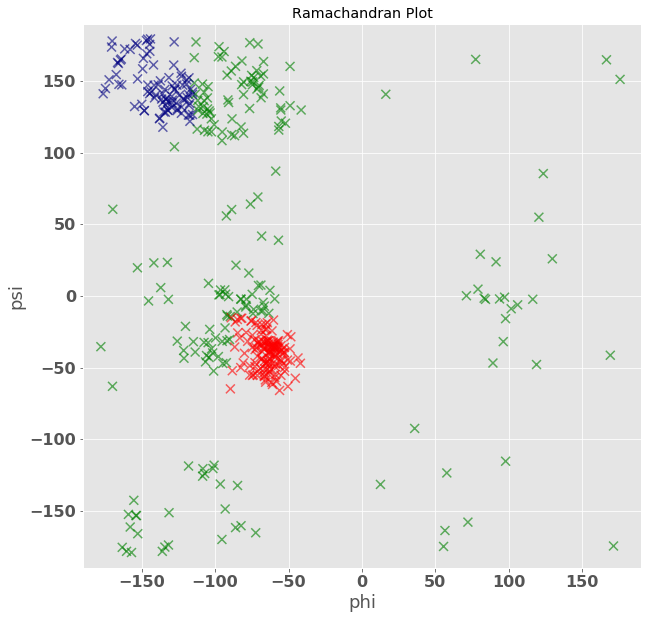

In [36]:
#RAMACHANDRAN PLOT SOLO ANGULOS
angulos.plot.scatter('phi','psi', title='Ramachandran Plot', 
                     c = angulos.color_SS.values.tolist(),
                     marker = 'x',
                     alpha=0.6, figsize=(10,10), s=80
                    )
limite1,limite2 = -190,190
plt.xlim(limite1,limite2)
plt.ylim(limite1,limite2);